# Land Cover Classification using Deep Learning Techniques and EuroSAT

## Mounting google drive for dataset access and saving models

## Libraries

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 644 µs (started: 2022-05-01 00:50:23 +00:00)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
import random


from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib
matplotlib.rcParams['axes.grid'] = False

time: 3.02 s (started: 2022-05-01 00:50:23 +00:00)


## Config

In [3]:
ROOT_PATH = './'
BASE_PATH = '../input/wgangpdata/Dataset'
FULL_DATA_DF = os.path.join(ROOT_PATH, 'dataset_label.csv')

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(1021)
TEST_SIZE = 0.25

approach = "Resnet"

time: 4.28 ms (started: 2022-05-01 00:50:26 +00:00)


## Utils

In [4]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

time: 1.12 ms (started: 2022-05-01 00:50:26 +00:00)


In [5]:
## Example for decoding and encoding
print(encode_label('Forest'))
print(decode_target(1))
print(decode_target(2, text_labels=True))

1
Forest
HerbaceousVegetation
time: 922 µs (started: 2022-05-01 00:50:27 +00:00)


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [6]:
print(f"Total number of images in the dataset: {len(os.listdir(BASE_PATH))}")

Total number of images in the dataset: 29560
time: 469 ms (started: 2022-05-01 00:50:27 +00:00)


In [7]:
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   for each_file in filename:

for each_file in os.listdir(BASE_PATH):
    DATA_DF.loc[i] = [each_file, each_file.split('_')[0]]
    i += 1
print(i)
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()


29560


,image_id,label
0,Forest_2838.jpg,Forest
1,AnnualCrop_1184.jpg,AnnualCrop
2,River_1705.jpg,River
3,HerbaceousVegetation_1224.jpg,HerbaceousVegetation
4,HerbaceousVegetation_1712.jpg,HerbaceousVegetation


time: 1min 32s (started: 2022-05-01 00:50:28 +00:00)


In [8]:
print(f"Uniques values for labels are...")
for ind, each in enumerate(DATA_DF.label.unique()):
  print(ind+1, ":", each)

Uniques values for labels are...
1 : Forest
2 : AnnualCrop
3 : River
4 : HerbaceousVegetation
5 : Pasture
6 : Industrial
7 : Residential
8 : PermanentCrop
9 : SeaLake
10 : Highway
time: 9 ms (started: 2022-05-01 00:52:01 +00:00)


## Processing data folders to train and test


In [9]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*TEST_SIZE)]
TEST_DF = DATA_DF[-int(len(DATA_DF)*TEST_SIZE) :]

time: 29.8 ms (started: 2022-05-01 00:52:01 +00:00)


In [10]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,16121,River_795.jpg,River
1,11298,SeaLake_2239.jpg,SeaLake
2,15653,Pasture_1536.jpg,Pasture
3,23158,SeaLake_2395.jpg,SeaLake
4,28704,SeaLake_152.jpg,SeaLake


time: 8.56 ms (started: 2022-05-01 00:52:01 +00:00)


In [11]:
TEST_DF.reset_index(inplace = True) 
TEST_DF.head()

,index,image_id,label
0,13046,SeaLake_1830.jpg,SeaLake
1,1779,HerbaceousVegetation_2565.jpg,HerbaceousVegetation
2,25556,Forest_1523.jpg,Forest
3,15037,River_2266.jpg,River
4,25455,Residential_1952.jpg,Residential


time: 8.01 ms (started: 2022-05-01 00:52:01 +00:00)


In [12]:
len(TRAIN_DF.index), len(TEST_DF.index)

(22170, 7390)

time: 2.74 ms (started: 2022-05-01 00:52:01 +00:00)


## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [13]:
class EuroSAT(Dataset):
    def __init__(self, df, dirc, transform=None):
        self.train_dir = dirc
        self.train_df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

time: 1.18 ms (started: 2022-05-01 00:52:02 +00:00)


### Transformations and Datasets

In [14]:
## Dataset and transformations
train_data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(20),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                ])

test_data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                ])

time: 1.39 ms (started: 2022-05-01 00:52:02 +00:00)


In [15]:
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, train_data_transform)
test_ds = EuroSAT(TEST_DF, BASE_PATH, test_data_transform)
print(len(train_ds), len(test_ds))

22170 7390
time: 1.04 ms (started: 2022-05-01 00:52:02 +00:00)


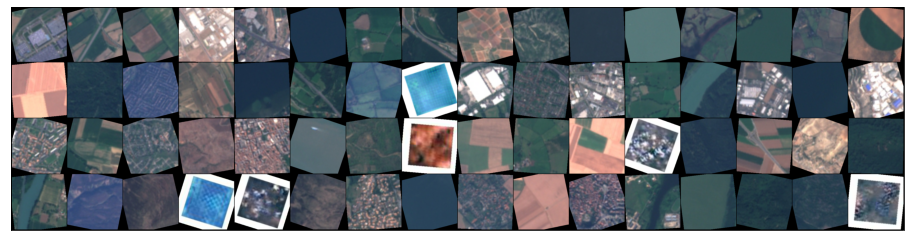

time: 5.71 s (started: 2022-05-01 00:52:02 +00:00)


In [16]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss

    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

time: 2.13 ms (started: 2022-05-01 00:52:08 +00:00)


In [18]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

time: 1.91 ms (started: 2022-05-01 00:52:08 +00:00)


In [19]:
model = LULC_Model()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

time: 8.6 s (started: 2022-05-01 00:52:09 +00:00)


In [20]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
        
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.2321, -2.1890, -2.4415, -2.4403, -2.3057, -2.4598, -2.2614, -2.3233,
        -2.1251, -2.3048], grad_fn=<SelectBackward>)
time: 37.8 s (started: 2022-05-01 00:52:17 +00:00)


## Training and Evaluating

In [21]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

time: 3.66 ms (started: 2022-05-01 00:52:56 +00:00)


## Initializing Device also Loading Data and Model to device¶


In [22]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

time: 1.68 ms (started: 2022-05-01 00:52:56 +00:00)


In [23]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.0392, -2.4661, -2.5326, -2.4092, -2.2555, -2.4140, -2.1444, -2.4335,
        -1.9803, -2.5454], device='cuda:0', grad_fn=<SelectBackward>)
time: 8.84 s (started: 2022-05-01 00:52:56 +00:00)


In [24]:
torch.cuda.empty_cache()

time: 152 ms (started: 2022-05-01 00:53:05 +00:00)


## Training

In [25]:
## Hyper Parameters
max_epochs_stop = 5
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 0
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 25
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, test_dl)

{'val_loss': 2.29352068901062, 'val_acc': 0.11693605780601501}

time: 33.9 s (started: 2022-05-01 00:53:06 +00:00)


In [26]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, test_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9022, learning_rate: 0.0001, train_loss: 0.3482, val_loss: 0.1694, val_acc: 0.9473


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9584, learning_rate: 0.0001, train_loss: 0.1346, val_loss: 0.0860, val_acc: 0.9733


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9666, learning_rate: 0.0001, train_loss: 0.1065, val_loss: 0.0635, val_acc: 0.9779


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9741, learning_rate: 0.0001, train_loss: 0.0863, val_loss: 0.0844, val_acc: 0.9728


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9758, learning_rate: 0.0001, train_loss: 0.0794, val_loss: 0.0734, val_acc: 0.9777


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9776, learning_rate: 0.0001, train_loss: 0.0720, val_loss: 0.1028, val_acc: 0.9666


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9884, learning_rate: 0.0000, train_loss: 0.0393, val_loss: 0.0350, val_acc: 0.9879


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9921, learning_rate: 0.0000, train_loss: 0.0266, val_loss: 0.0336, val_acc: 0.9891


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9935, learning_rate: 0.0000, train_loss: 0.0222, val_loss: 0.0329, val_acc: 0.9892


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9931, learning_rate: 0.0000, train_loss: 0.0212, val_loss: 0.0337, val_acc: 0.9898


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9935, learning_rate: 0.0000, train_loss: 0.0205, val_loss: 0.0343, val_acc: 0.9896


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9941, learning_rate: 0.0000, train_loss: 0.0185, val_loss: 0.0318, val_acc: 0.9899


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9956, learning_rate: 0.0000, train_loss: 0.0155, val_loss: 0.0378, val_acc: 0.9886


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9960, learning_rate: 0.0000, train_loss: 0.0147, val_loss: 0.0319, val_acc: 0.9904


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9959, learning_rate: 0.0000, train_loss: 0.0127, val_loss: 0.0337, val_acc: 0.9891


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.9957, learning_rate: 0.0000, train_loss: 0.0125, val_loss: 0.0311, val_acc: 0.9906


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.9970, learning_rate: 0.0000, train_loss: 0.0104, val_loss: 0.0314, val_acc: 0.9904


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.9968, learning_rate: 0.0000, train_loss: 0.0105, val_loss: 0.0309, val_acc: 0.9912


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.9967, learning_rate: 0.0000, train_loss: 0.0100, val_loss: 0.0304, val_acc: 0.9907


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.9971, learning_rate: 0.0000, train_loss: 0.0094, val_loss: 0.0317, val_acc: 0.9906


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.9973, learning_rate: 0.0000, train_loss: 0.0095, val_loss: 0.0308, val_acc: 0.9906


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.9975, learning_rate: 0.0000, train_loss: 0.0085, val_loss: 0.0307, val_acc: 0.9910


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.9982, learning_rate: 0.0000, train_loss: 0.0077, val_loss: 0.0310, val_acc: 0.9908


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.9975, learning_rate: 0.0000, train_loss: 0.0087, val_loss: 0.0305, val_acc: 0.9911


  0%|          | 0/347 [00:00<?, ?it/s]

Epoch [24],train_accu: 0.9973, learning_rate: 0.0000, train_loss: 0.0091, val_loss: 0.0298, val_acc: 0.9912
VAL LOSS MIN 0.029770972207188606
VAL ACC MAX 0.9912446141242981
time: 1h 37min 53s (started: 2022-05-01 00:53:40 +00:00)


## Reports

### Training Reports

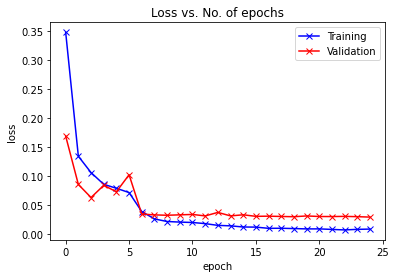

time: 272 ms (started: 2022-05-01 02:31:34 +00:00)


In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

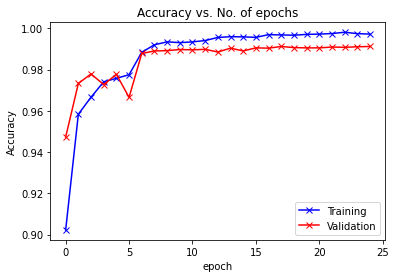

time: 259 ms (started: 2022-05-01 02:31:35 +00:00)


In [28]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

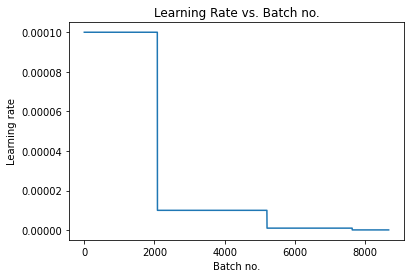

time: 215 ms (started: 2022-05-01 02:31:36 +00:00)


In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

## Evaluation on test dataset

In [30]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("./lulc_max_acc.pth"))
model.eval()
model = to_device(model, device)

time: 1.56 s (started: 2022-05-01 02:31:36 +00:00)


In [31]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

time: 1.1 ms (started: 2022-05-01 02:31:38 +00:00)


In [32]:
device = get_device()
## Loading data to devide
batch_size =1
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

True
time: 1.14 ms (started: 2022-05-01 02:31:39 +00:00)


In [33]:
predictions, labels = predict_dl(test_dl, model)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

  0%|          | 0/7390 [00:00<?, ?it/s]

time: 2min 7s (started: 2022-05-01 02:31:39 +00:00)


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(labs, preds)
cm = cm / cm.astype(np.float).sum(axis=1)
cm = np.round(cm, 4) * 100
acc = accuracy_score(labs, preds)
print(f'''Accuracy of test data is: {acc*100:.2f} %''' )

Accuracy of test data is: 99.12 %
time: 19 ms (started: 2022-05-01 02:33:47 +00:00)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


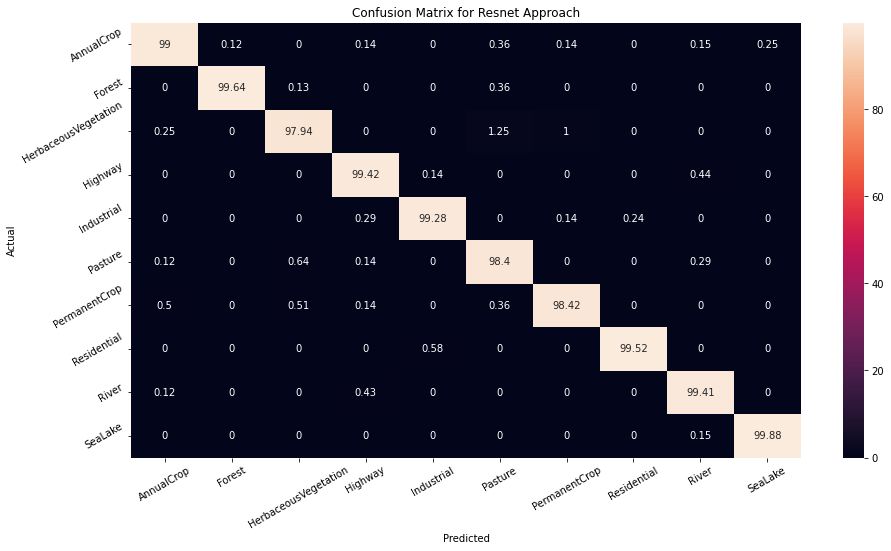

time: 771 ms (started: 2022-05-01 02:33:47 +00:00)


In [35]:
plt.figure(figsize = (15,8))
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title(f'Confusion Matrix for {approach} Approach');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.yticks(rotation=30) 
plt.xticks(rotation=30) 
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.show()

### Prediction Reports

<Figure size 432x288 with 0 Axes>

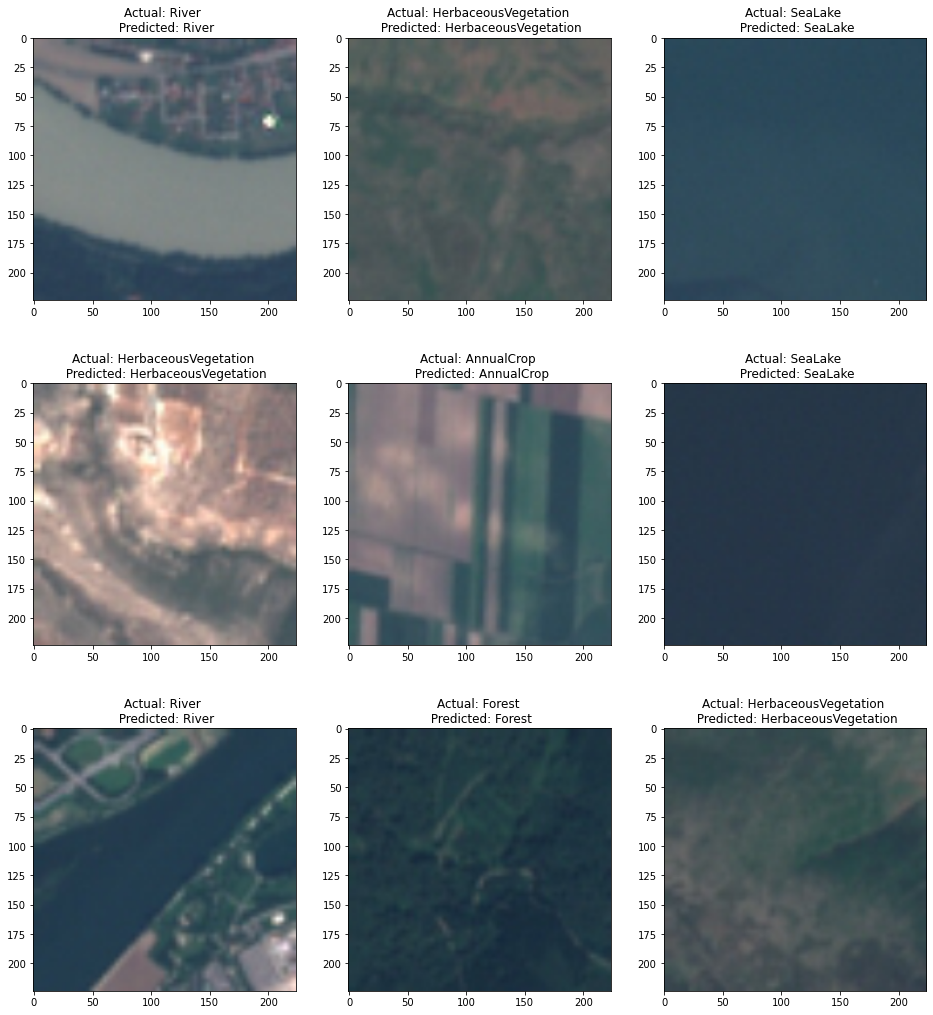

time: 2.22 s (started: 2022-05-01 02:33:49 +00:00)


In [36]:
### Predict Single Images
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)

def plot_samples(img_dir, rows=3, cols=3):
    plt.figure()
    f, axs = plt.subplots(rows, cols, figsize=(16, 18))
    k = 120
    for i in range(rows):
        for j in range(cols):
            predicted = predict_single(test_ds[k][0])
            actual = decode_target(test_ds[k][1], text_labels=True)
            text = f"Actual: {actual} \n Predicted: {predicted}"
            axs[i, j].title.set_text(text)
            axs[i, j].imshow(test_ds[k][0].permute(1, 2, 0))
            
            k += 1

plot_samples(BASE_PATH)

# Evaluation on overall dataset

In [37]:
device = get_device()
## Loading data to devide
batch_size =1
test_ds = EuroSAT(DATA_DF, BASE_PATH, test_data_transform)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

True
time: 1.29 ms (started: 2022-05-01 02:33:51 +00:00)


In [38]:
predictions, labels = predict_dl(test_dl, model)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

  0%|          | 0/29560 [00:00<?, ?it/s]

time: 8min 32s (started: 2022-05-01 02:33:52 +00:00)


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(labs, preds)
cm = cm / cm.astype(np.float).sum(axis=1)
cm = np.round(cm, 4) * 100
acc = accuracy_score(labs, preds)
print(f'''Accuracy of overall data is: {acc*100:.2f} %''' )

Accuracy of overall data is: 99.73 %
time: 50.2 ms (started: 2022-05-01 02:42:25 +00:00)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


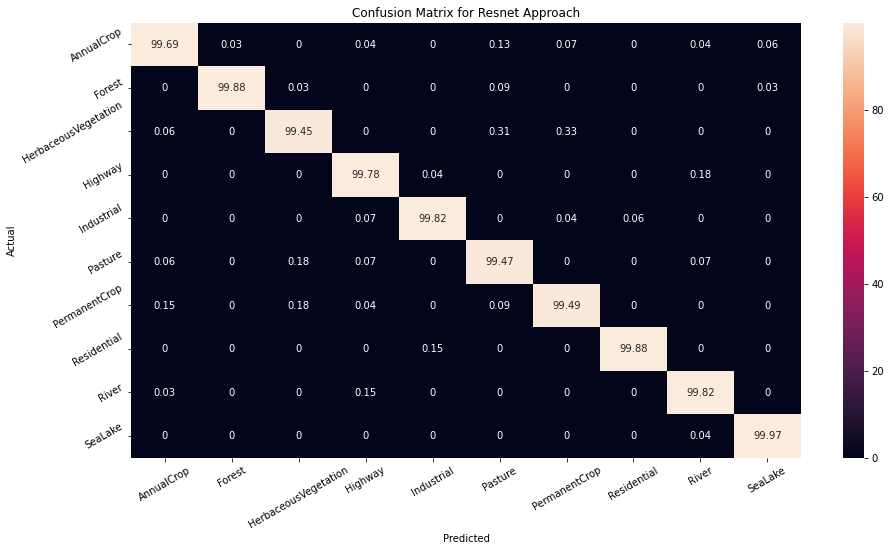

time: 965 ms (started: 2022-05-01 02:42:25 +00:00)


In [40]:
plt.figure(figsize = (15,8))
ax = sns.heatmap(cm, annot=True, fmt='g');
ax.set_title(f'Confusion Matrix for {approach} Approach');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');
plt.yticks(rotation=30) 
plt.xticks(rotation=30) 
## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)
plt.show()